# Image captioning with visual attention
This notebook is based on tensorflow page for image captioning.
https://www.tensorflow.org/tutorials/text/image_captioning

The model architecture is similar to https://arxiv.org/abs/1502.03044

## Import
This has all imports

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import keras

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

Using TensorFlow backend.


### Imports and dowload for Google Coloab or AWS Sage Maker
This make downloads and import for help use cloud solutions

In [2]:
!pip install -q tqdm

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [3]:
from tqdm import tqdm

### GPU
Print if has gpu avalilable

In [4]:
tf.version.VERSION

'2.1.0'

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Download
Donwload all data from dataset

The dataset contains over 82,000 images, each of which has at least 5 different caption annotations. The code below downloads and extracts the dataset. The following methods enable for download the dataset, if it already exists into target path, do not replace it and do not make download.

### Download annotations

In [7]:
def download_annotations(name_of_zip='captions.zip'):
    annotation_zip = keras.utils.get_file(
        name_of_zip,
        cache_subdir=os.path.abspath('.'),
        origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
        extract=True)
    return f'{os.path.dirname(annotation_zip)}/annotations/captions_train2014.json'

In [8]:
annotation_file = download_annotations()

### Donwload images

In [9]:
def download_dataset(name_of_zip='train2014.zip', folder_to_extract='train2014'):
    if not os.path.exists(f'{os.path.abspath(".")}/{name_of_zip}'):
        image_zip = keras.utils.get_file(
            name_of_zip,
            cache_subdir=os.path.abspath('.'),
            origin='http://images.cocodataset.org/zips/train2014.zip',
            extract=True)
        return f'{os.path.dirname(image_zip)}/{folder_to_extract}/'
    else:
        return f'{os.path.abspath(".")}/{folder_to_extract}/'

In [10]:
train_folder = download_dataset()

## Preprocessing
Preparing and processing all annotations and images to enable train

### Get images vector and annotations
Read file and create vectors with caption and images path

#### Read file
Read file and create variables with all captions and vector of image names

In [11]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [12]:
all_captions = []
all_img_name_vector = []

All annotations is make for this pattern: `<start>caption<end>` when `caption` are from annotations.
All image name vector follow this pattern: start with `COCO_train2014_` follow by image id, that have 12 numbers and has lenght equals 12, with the image extension, like `jpg`.

After processing all images, create two vectors, `all_captions` and `all_img_name_vector`.

In [13]:
for annotation in annotations['annotations']:
    caption = f'<start>{annotation["caption"]}<end>'
    image_id = annotation['image_id']
    coco_image_path = train_folder + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector.append(coco_image_path)
    all_captions.append(caption)

#### Suffle dataset
Suffle data using `sklearn.shuffle`

In [14]:
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector)

In [15]:
len(train_captions), len(all_captions)

(414113, 414113)

### Preprocess the images using InceptionV3

First convert the images into InceptionV3's expected format by: __Resizing the image to 299px by 299px__

This method allow for map `all_img_name_vector`
The steps for it:
- read file, using the method parameter
- transform image to tensors, with 3 color channels
- resize image for inceptionV3 size, 299 by 299
- using `tensorflow.keras.applications.inception_v3.preprocess_input` for generate inceptionv3 input

In [16]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

#### Initialize InceptionV3 and load the pretrained Imagenet weights
Donwload inceptionv3, using keras, pre trained with imagenet dataset. Do not include top because it is not relevant here.

In [17]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

87916544/87910968 [==============================] - 1s 0us/step


#### Create image dataset
Create a set with `img_name_vector` for remove duplicate images before create map with that set.

In [18]:
encode_train = sorted(set(img_name_vector))

The mal call function `load_image` that processing image for create input. This map using a batch for more fast processing.

In [19]:
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

#### Cache processing images
Processing the images with convolutional layers from InceptionV3

Each image_dataset, that is a map from `load_image`. Image batch are processing by `image_model`, from InvecptionV3, when return a features extracted from original image, thus are reshaped for reverse axis 2 and save the numpy file with features in disk storage.

In [20]:
for img, path in tqdm(image_dataset):
    batch_features = image_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

1294it [15:23,  1.40it/s]


## Preprocess and tokenize the captions
Captions processing using the top 10000 most comons words that found there for create a vocabulary.

In [21]:
top_k = 10000

Find the maximum length of any caption in dataset

In [22]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

#### Create tokenizer
Choose the top words from the vocabulary, determine by `top_k`. This method: `tf.keras.preprocessing.text.Tokeniezer` will be create  a utils method for create sequence by character.

In [23]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

#### Fit text with captions
After create `tokenizer`, fit it with the captions.

In [24]:
tokenizer.fit_on_texts(train_captions)

After fit tokenizer, create sequeces by captions. This sequence are based on fit.

In [25]:
train_seqs = tokenizer.texts_to_sequences(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

Pad each vector to the max_length of the captions

If you do not provide a max_length value, pad_sequences calculates it automatically

In [26]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

Calculates the max_length, which is used to store the attention weights

In [27]:
max_length = calc_max_length(train_seqs)

#### Split the data into training and testing
Create training and validation sets using an 80-20 split

In [28]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [29]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(331290, 331290, 82823, 82823)

## Hyperparameter
Feel free to change these parameters according to your system's configuration

In [30]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train)

Shape of the vector extracted from InceptionV3 is (64, 2048)

These two variables represent that vector shape

In [31]:
features_shape = 2048
attention_features_shape = 64

## Model
Create model for trainning

In [32]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 64, 1)
        # you get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [33]:
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [34]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

Cretate instance of models

In [35]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

### Define optimizer

In [36]:
optimizer = tf.keras.optimizers.Adam()

### Define loss function

In [37]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

## Training
Train the data with features

### Load numpy files
This help to load numpy files, that contains a result of image after convolutionals of inceptionv3.

In [38]:
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

In [39]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

In [40]:
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

Shuffle and batch from images features

In [41]:
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### Checkpoint

In [42]:
checkpoint_path = "./checkpoints/train"

In [43]:
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)

In [44]:
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [45]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

### Train

Adding this in a separate cell because if you run the training cell many times, the loss_plot array will be reset

In [46]:
loss_plot = []

initializing the hidden state for each batch
because the captions are not related from image to image

In [47]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [ ]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
          ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1, total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.0685
Epoch 1 Batch 100 Loss 1.0570
Epoch 1 Batch 200 Loss 0.9810
Epoch 1 Batch 300 Loss 1.0107
Epoch 1 Batch 400 Loss 0.8802
Epoch 1 Batch 500 Loss 0.7644
Epoch 1 Batch 600 Loss 0.7957
Epoch 1 Batch 700 Loss 0.8327
Epoch 1 Batch 800 Loss 0.7257
Epoch 1 Batch 900 Loss 0.7326
Epoch 1 Batch 1000 Loss 0.7984
Epoch 1 Batch 1100 Loss 0.7114
Epoch 1 Batch 1200 Loss 0.6866
Epoch 1 Batch 1300 Loss 0.6891
Epoch 1 Batch 1400 Loss 0.7482
Epoch 1 Batch 1500 Loss 0.6618
Epoch 1 Batch 1600 Loss 0.7446
Epoch 1 Batch 1700 Loss 0.6881
Epoch 1 Batch 1800 Loss 0.7380
Epoch 1 Batch 1900 Loss 0.6635
Epoch 1 Batch 2000 Loss 0.6341
Epoch 1 Batch 2100 Loss 0.7100
Epoch 1 Batch 2200 Loss 0.6562
Epoch 1 Batch 2300 Loss 0.7020
Epoch 1 Batch 2400 Loss 0.6661
Epoch 1 Batch 2500 Loss 0.6794
Epoch 1 Batch 2600 Loss 0.6770
Epoch 1 Batch 2700 Loss 0.6250
Epoch 1 Batch 2800 Loss 0.6885
Epoch 1 Batch 2900 Loss 0.6761
Epoch 1 Batch 3000 Loss 0.7046
Epoch 1 Batch 3100 Loss 0.6501
Epoch 1 Batch 3200 L

Epoch 5 Batch 5000 Loss 0.5300
Epoch 5 Batch 5100 Loss 0.5031
Epoch 5 Loss 0.008397
Time taken for 1 epoch 3501.0744445323944 sec

Epoch 6 Batch 0 Loss 0.5597
Epoch 6 Batch 100 Loss 0.5162
Epoch 6 Batch 200 Loss 0.4991
Epoch 6 Batch 300 Loss 0.5036
Epoch 6 Batch 400 Loss 0.5099
Epoch 6 Batch 500 Loss 0.5530
Epoch 6 Batch 600 Loss 0.5339
Epoch 6 Batch 700 Loss 0.5195
Epoch 6 Batch 800 Loss 0.5226
Epoch 6 Batch 900 Loss 0.5548
Epoch 6 Batch 1000 Loss 0.4539
Epoch 6 Batch 1100 Loss 0.4840
Epoch 6 Batch 1200 Loss 0.5464
Epoch 6 Batch 1300 Loss 0.4895
Epoch 6 Batch 1400 Loss 0.5362
Epoch 6 Batch 1500 Loss 0.5472
Epoch 6 Batch 1600 Loss 0.5106
Epoch 6 Batch 1700 Loss 0.5122
Epoch 6 Batch 1800 Loss 0.5597
Epoch 6 Batch 1900 Loss 0.5354
Epoch 6 Batch 2000 Loss 0.5381
Epoch 6 Batch 2100 Loss 0.5351
Epoch 6 Batch 2200 Loss 0.6017
Epoch 6 Batch 2300 Loss 0.5182
Epoch 6 Batch 2400 Loss 0.5177
Epoch 6 Batch 2500 Loss 0.5556
Epoch 6 Batch 2600 Loss 0.5204
Epoch 6 Batch 2700 Loss 0.5396
Epoch 6 Batch

### Plot loss by epoch

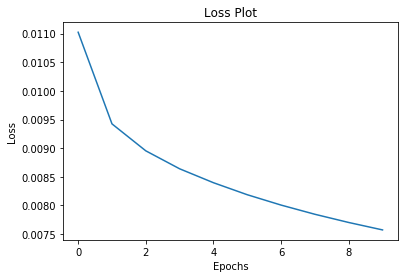

In [49]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption
Evaluate caption from train and plot it

In [53]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [54]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

### Captions on the validation set

Real Caption: <start>a hotdog bun that is resting on a bunch of hotdogs <end>
Prediction Caption: sandwich buns grilling on a buns <end>


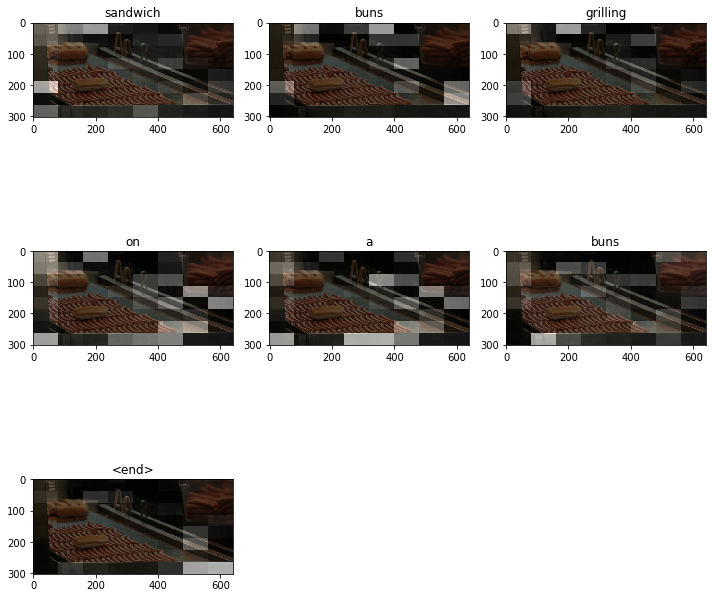

In [55]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

### Try images

65536/64400 [==============================] - 0s 1us/step
Prediction Caption: riding a wave into the waves under a wave <end>


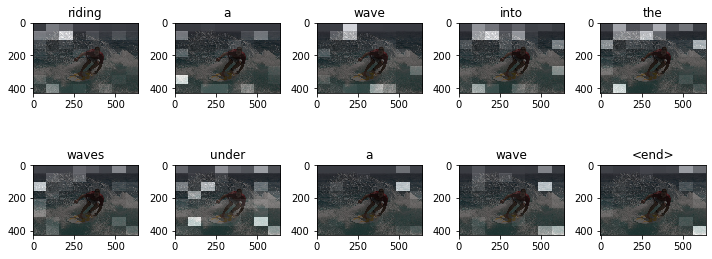

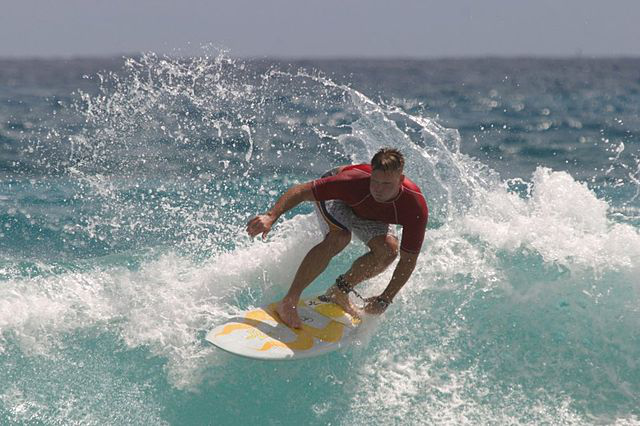

In [56]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)

Image.open(image_path)